### Sentimental Analysis With Amazon Customer Review For Musical Instruments

##### Importing all libraries

In [1]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import spacy
from sklearn.model_selection import train_test_split
from nltk.tokenize import RegexpTokenizer
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
import string
from string import punctuation
import collections
from collections import Counter
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics import accuracy_score
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.model_selection import cross_val_score
import re

In [2]:
# Loading the data

raw_reviews = pd.read_csv('Musical_instruments_reviews.csv')
raw_reviews.head()

,reviewerID,asin,reviewerName,helpful,reviewText,overall,summary,unixReviewTime,reviewTime
0,A2IBPI20UZIR0U,1384719342,"cassandra tu ""Yeah, well, that's just like, u...","[0, 0]","Not much to write about here, but it does exac...",5.0,good,1393545600,"02 28, 2014"
1,A14VAT5EAX3D9S,1384719342,Jake,"[13, 14]",The product does exactly as it should and is q...,5.0,Jake,1363392000,"03 16, 2013"
2,A195EZSQDW3E21,1384719342,"Rick Bennette ""Rick Bennette""","[1, 1]",The primary job of this device is to block the...,5.0,It Does The Job Well,1377648000,"08 28, 2013"
3,A2C00NNG1ZQQG2,1384719342,"RustyBill ""Sunday Rocker""","[0, 0]",Nice windscreen protects my MXL mic and preven...,5.0,GOOD WINDSCREEN FOR THE MONEY,1392336000,"02 14, 2014"
4,A94QU4C90B1AX,1384719342,SEAN MASLANKA,"[0, 0]",This pop filter is great. It looks and perform...,5.0,No more pops when I record my vocals.,1392940800,"02 21, 2014"


In [3]:
raw_reviews.shape

(10261, 9)

In [4]:
# Removing unwanted feature in primary Analysis

raw_reviews = raw_reviews.drop(['reviewerID', 'asin','reviewerName', 'unixReviewTime', 'helpful','reviewTime'], axis = 1)
raw_reviews.head()

,reviewText,overall,summary
0,"Not much to write about here, but it does exac...",5.0,good
1,The product does exactly as it should and is q...,5.0,Jake
2,The primary job of this device is to block the...,5.0,It Does The Job Well
3,Nice windscreen protects my MXL mic and preven...,5.0,GOOD WINDSCREEN FOR THE MONEY
4,This pop filter is great. It looks and perform...,5.0,No more pops when I record my vocals.


In [5]:
#Creating a copy
process_reviews=raw_reviews.copy()

#Checking for null values
process_reviews.isnull().sum()

reviewText    7
overall       0
summary       0
dtype: int64

In [6]:
# Handling Missing Values with fillna

process_reviews['reviewText']=process_reviews['reviewText'].fillna('Missing')

## Concatenating review text and summary


In [7]:
process_reviews['reviews']=process_reviews['reviewText']+process_reviews['summary']
process_reviews=process_reviews.drop(['reviewText', 'summary'], axis=1)
process_reviews.head()

,overall,reviews
0,5.0,"Not much to write about here, but it does exac..."
1,5.0,The product does exactly as it should and is q...
2,5.0,The primary job of this device is to block the...
3,5.0,Nice windscreen protects my MXL mic and preven...
4,5.0,This pop filter is great. It looks and perform...


### Creating 'sentiment' column


This is an important preprocessing phase, we are deciding the outcome column (sentiment of review) based on the overall score. 

--> If the score is greater than 3, we take that as positive and

--> if the value is less than 3 it is negative 

--> Ifit is equal to 3, we take that as neutral sentiment

In [8]:
#Figuring out the distribution of categories
process_reviews['overall'].value_counts()

5.0    6938
4.0    2084
3.0     772
2.0     250
1.0     217
Name: overall, dtype: int64

In [9]:
def rating(overall):
    
    if (int(overall == 3.0)):
        return ('average')
    elif (int(overall == 4.0 ) or int(overall == 5.0 )):
        return ('positive')
    else:
        return ('bad')    
    
process_reviews['sentiment'] = process_reviews['overall'].apply(rating)
process_reviews = process_reviews.drop(['overall'], axis = 1)
process_reviews.head()

,reviews,sentiment
0,"Not much to write about here, but it does exac...",positive
1,The product does exactly as it should and is q...,positive
2,The primary job of this device is to block the...,positive
3,Nice windscreen protects my MXL mic and preven...,positive
4,This pop filter is great. It looks and perform...,positive


C:\Users\jayes\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='sentiment', ylabel='count'>

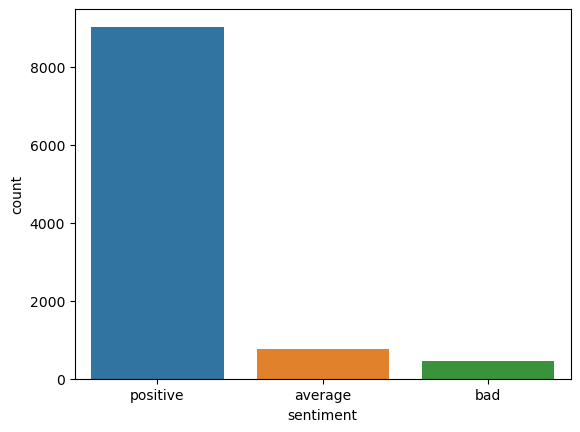

In [10]:
process_reviews['sentiment'].value_counts()
sns.countplot(process_reviews.sentiment)

In [11]:
#Creating a copy 
clean_reviews=process_reviews.copy()

## Review text-Punctuation Cleaning

'''Make text lowercase, remove text in square brackets,remove links,remove punctuation
    and remove words containing numbers.'''

In [13]:
nlp = spacy.load("en_core_web_sm")
tokenizer = RegexpTokenizer(r'\w+')     # Tokenisation
lemmatizer = WordNetLemmatizer()        # Lemmatizaton
stop = set(stopwords.words('english'))  # Stopwords removing
punctuation = list(string.punctuation)
stop.update(punctuation)

            
def furnished(text):
    final_text = []
    for i in text.split():
        if i.lower() not in stop:
            word = lemmatizer.lemmatize(i)
            final_text.append(word.lower())
    return " ".join(final_text)


            
process_reviews.reviews = process_reviews.reviews.apply(furnished)

In [14]:
process_reviews[process_reviews['sentiment']=='bad']

,reviews,sentiment
15,bought use keyboard. really aware option keybo...,bad
50,expect cable thin. easily 1/2 thickness guitar...,bad
52,"hums, crackles, think i'm problem equipment. s...",bad
89,"i'm pro-cheapo hated thing. they're noisy, cab...",bad
98,bought canon vixia hf g10 video camera shotgun...,bad
...,...,...
10171,"really wanted like these, they're frickin, lin...",bad
10178,larger one sometimes neck snap thought might a...,bad
10187,tension screw adjustment remains best capo i'v...,bad
10189,"fan planet waves ns capos, new one well design...",bad


In [15]:
inp=process_reviews.loc[7][0]
inp

"use cable run output pedal chain input fender amp. bought monster cable hook pedal board thought would try another one update guitar. using high end planet waves cable bought 1980's... found input jack new monster cable fit fender strat jack little disappointed... return stated use output pedal board. save money... went back planet waves cable...i payed $30.00 back eighty planet waves come around $50.00. i'm getting get pay for. thought waves lot money back day...but bought guitar cable since one...20 plus year still working...planet waves wins.didn't fit 1996 fender strat..."

In [16]:
process_reviews.reviews.describe()

count                      10261
unique                     10256
top       good stringsfive stars
freq                           3
Name: reviews, dtype: object

<AxesSubplot:>

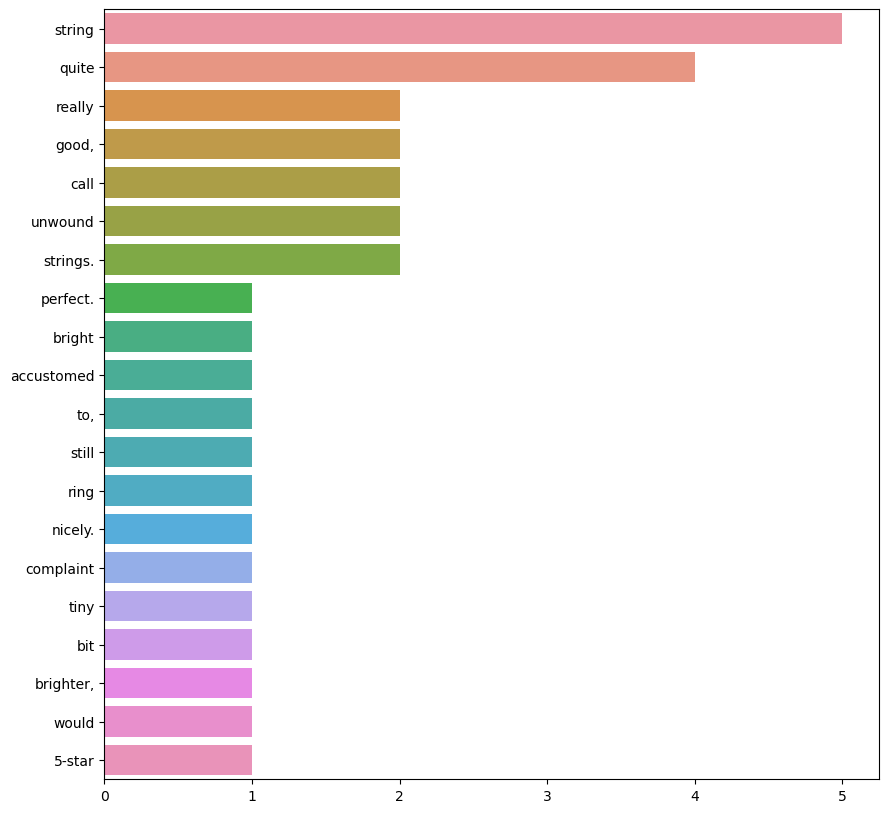

In [17]:
for i in process_reviews.reviews:
    global text
    text = i.split()
    
counter=Counter(text)
most=counter.most_common()

x, y= [], []
for word,count in most[:20]:
    if (word not in stop):
        x.append(word)
        y.append(count)
plt.figure(figsize = (10,10))     
sns.barplot(x=y,y=x)

In [18]:
process_reviews.head()

,reviews,sentiment
0,"much write here, exactly supposed to. filter p...",positive
1,product exactly quite affordable.i realized do...,positive
2,primary job device block breath would otherwis...,positive
3,nice windscreen protects mxl mic prevents pops...,positive
4,pop filter great. look performs like studio fi...,positive


In [19]:
x_train,x_test,y_train,y_test = train_test_split(process_reviews.reviews,process_reviews.sentiment,test_size = 0.2 , random_state = 0)


In [20]:
#bow
cv=CountVectorizer(min_df=0,max_df=1,binary=False,ngram_range=(1,3))
bow_x_train = cv.fit_transform(x_train)
bow_x_test = cv.transform(x_test)

print('bow_x_train:',bow_x_train.shape)
print('bow_x_test:',bow_x_test.shape)

bow_x_train: (8208, 590454)
bow_x_test: (2053, 590454)


In [21]:
#tf-idf 
tv=TfidfVectorizer(min_df=0,max_df=1,use_idf=True,ngram_range=(1,3))

tfidf_x_train =tv.fit_transform(x_train)
tfidf_x_test =tv.transform(x_test)

print('tfidf_x_train:',tfidf_x_train.shape)
print('tfidf_x_test:',tfidf_x_test.shape)

tfidf_x_train: (8208, 590454)
tfidf_x_test: (2053, 590454)


In [22]:
#Naive Bayes
nb = MultinomialNB()

#fit
bow = nb.fit(bow_x_train, y_train)
tfidf = nb.fit(tfidf_x_train, y_train)


#predict
bow_predict = nb.predict(bow_x_test)
tfidf_predict = nb.predict(tfidf_x_test)

#accuracy
nb_bow = accuracy_score(y_test, bow_predict)
nb_tfidf = accuracy_score(y_test,tfidf_predict)

print('nb bow accuracy:', nb_bow)
print('tfidf accuracy:', nb_tfidf)

nb bow accuracy: 0.8894301022893327
tfidf accuracy: 0.8889430102289333


In [23]:
#Naive Bayes
nb = MultinomialNB()

#fit
bow = nb.fit(bow_x_train, y_train)
tfidf = nb.fit(tfidf_x_train, y_train)

#predict
bow_predict = nb.predict(bow_x_test)
tfidf_predict = nb.predict(tfidf_x_test)

#accuracy
nb_bow = accuracy_score(y_test, bow_predict)
nb_tfidf = accuracy_score(y_test,tfidf_predict)

print('nb bow accuracy:', nb_bow)
print('tfidf accuracy:', nb_tfidf)

nb bow accuracy: 0.8894301022893327
tfidf accuracy: 0.8889430102289333


In [24]:
#random forest
rf = RandomForestClassifier(n_estimators=200, max_depth=3, random_state=0)

#fit
bow = rf.fit(bow_x_train, y_train)
tfidf = rf.fit(tfidf_x_train, y_train)

#predict
bow_predict = rf.predict(bow_x_test)
tfidf_predict = rf.predict(tfidf_x_test)

#accuracy
rf_bow = accuracy_score(y_test, bow_predict)
rf_tfidf = accuracy_score(y_test,tfidf_predict)

print('rf bow accuracy:', rf_bow)
print('rf tfidf accuracy:', rf_tfidf)

rf bow accuracy: 0.8889430102289333
rf tfidf accuracy: 0.8889430102289333


In [25]:
#Linear SVC
ls =  LinearSVC()

#fit
bow = ls.fit(bow_x_train, y_train)
tfidf = ls.fit(tfidf_x_train, y_train)

#predict
bow_predict = ls.predict(bow_x_test)
tfidf_predict = ls.predict(tfidf_x_test)


#accuracy
ls_bow = accuracy_score(y_test, bow_predict)
ls_tfidf = accuracy_score(y_test,tfidf_predict)

print('ls bow accuracy:', ls_bow)
print('ls tfidf accuracy:', ls_tfidf)

ls bow accuracy: 0.8884559181685339
ls tfidf accuracy: 0.8899171943497322


In [26]:
#lr
lr = LogisticRegression(random_state=0)

#fit
bow = lr.fit(bow_x_train, y_train)
tfidf = lr.fit(tfidf_x_train, y_train)

#predict
bow_predict = lr.predict(bow_x_test)
tfidf_predict = lr.predict(tfidf_x_test)

#accuracy
lr_bow = accuracy_score(y_test, bow_predict)
lr_tfidf = accuracy_score(y_test,tfidf_predict)

print('lr bow accuracy:', lr_bow)
print('lr tfidf accuracy:', lr_tfidf)

lr bow accuracy: 0.8904042864101315
lr tfidf accuracy: 0.8889430102289333


In [27]:
data = {'accuracy': [nb_bow * 100, nb_tfidf * 100, rf_bow * 100, rf_tfidf * 100, lr_bow * 100, lr_tfidf * 100, ls_tfidf * 100, ls_bow * 100],
                   'model': ['naive bayes bow', 'naive bayes tfidf', 'random forest bow', 'random forest tfidf', 
                                'logit bow', 'logit tfidf', 'SVM bow', 'SVM tfidf']}
df = pd.DataFrame(data, columns = ['accuracy', 'model'])
df.head(8)

,accuracy,model
0,88.943010,naive bayes bow
1,88.894301,naive bayes tfidf
2,88.894301,random forest bow
3,88.894301,random forest tfidf
4,89.040429,logit bow
5,88.894301,logit tfidf
6,88.991719,SVM bow
7,88.845592,SVM tfidf


<AxesSubplot:xlabel='model', ylabel='accuracy'>

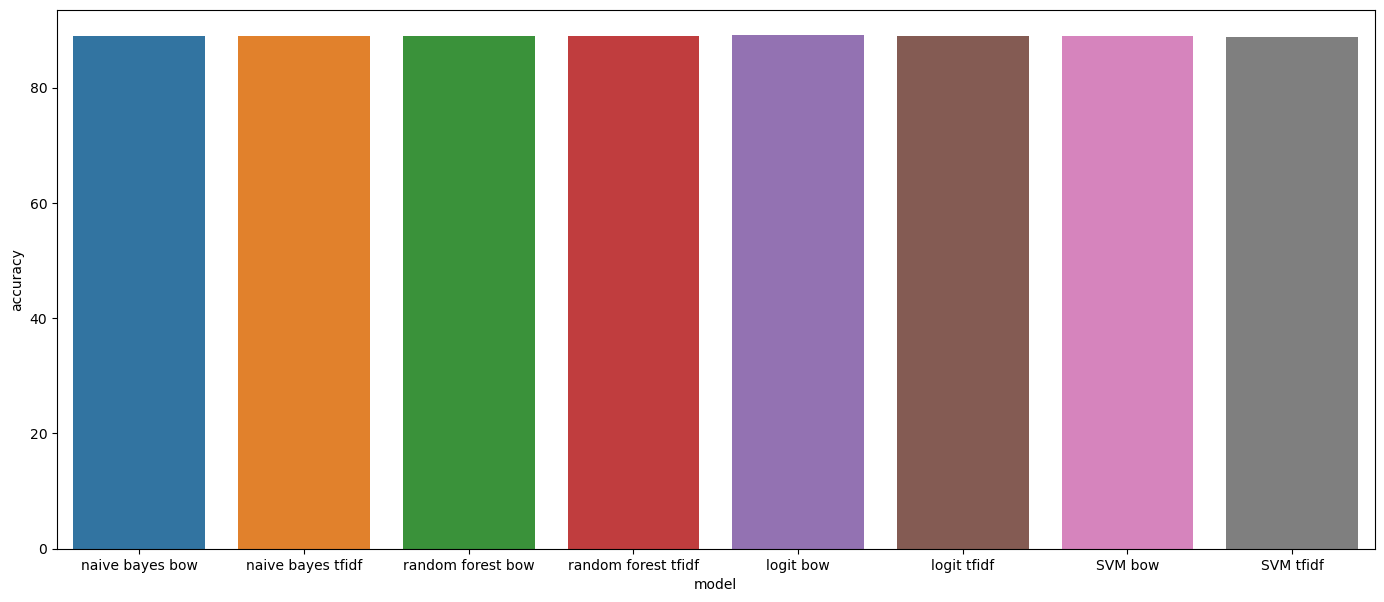

In [28]:
plt.figure(figsize = (17,7))
sns.barplot(y = df.accuracy, x = df.model)

In [38]:
inp = process_reviews.loc[0][0] #containing bad review data
bow_x_test = cv.transform([inp]) # wrap inp in square brackets to create a list of strings
# print('inp',bow_x_test)
print('inp',inp)
df_predit = nb.predict(bow_x_test)


inp much write here, exactly supposed to. filter pop sounds. recording much crisp. one lowest price pop filter amazon might well buy it, honestly work despite pricing,good


In [39]:
print('Product review:',df_predit)

Product review: ['positive']


In [40]:
inp = process_reviews.loc[7][0]  # containing avg review data
bow_x_test = cv.transform([inp]) # wrap inp in square brackets to create a list of strings
# print('inp',bow_x_test)
print('inp',inp)

inp use cable run output pedal chain input fender amp. bought monster cable hook pedal board thought would try another one update guitar. using high end planet waves cable bought 1980's... found input jack new monster cable fit fender strat jack little disappointed... return stated use output pedal board. save money... went back planet waves cable...i payed $30.00 back eighty planet waves come around $50.00. i'm getting get pay for. thought waves lot money back day...but bought guitar cable since one...20 plus year still working...planet waves wins.didn't fit 1996 fender strat...


In [41]:
df_predict = nb.predict(bow_x_test)
print('Product review:',df_predict)

Product review: ['average']


In [42]:
inp = process_reviews.loc[89][0] #containing bad review data
bow_x_test = cv.transform([inp]) # wrap inp in square brackets to create a list of strings
# print('inp',bow_x_test)
print('inp',inp)
df_predit = nb.predict(bow_x_test)


inp i'm pro-cheapo hated thing. they're noisy, cable feel really cheap, gummy-like. drop buck get something else!crap


In [43]:
print('Product review:',df_predit)

Product review: ['bad']


In [44]:
inputs = ['use cable run output pedal chain input fender amp. bought monster cable hook pedal board thought would try another one update guitar. using high end planet waves cable bought 1980 found  jack new monster cable fit fender strat jack little disappointed stated use output pedal board. save money... went back planet waves cable...i payed $30.00 back eighty planet waves come around $50.00 im getting get pay for. thought waves lot money back day...but bought guitar cable since one...20 plus year still working...planet waves wins.didnt fit 1996 fender strat']
bow_x_tes = cv.transform(inputs)
print('Vectorized output:', bow_x_tes.toarray())
df_predit = nb.predict(bow_x_tes)
print('Product review:',df_predit)


Vectorized output: [[0 0 0 ... 0 0 0]]
Product review: ['average']


In [45]:
inputs = ['im pro-cheapo hated thing. they re noisy, cable feel really cheap, gummy-like. drop buck get something else!crap']
bow_x_tes = cv.transform(inputs)
print('Vectorized output:', bow_x_tes.toarray())
df_predit = nb.predict(bow_x_tes)
print('Product review:',df_predit)

Vectorized output: [[0 0 0 ... 0 0 0]]
Product review: ['bad']
